### Notes:
* Based on [this tutorial](https://www.datascience.com/blog/python-anomaly-detection)
* Code updated to Python 3.0
* Mistakes corrected in the code (especially in the latter sections), to replicate diagrams correctly.

In [1]:
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style

## Sunspot dataset

### Load data 

In [2]:
# Numpy load txt.
data = np.loadtxt("sunspots.txt")
data

array([[0.000e+00, 5.800e+01],
       [1.000e+00, 6.260e+01],
       [2.000e+00, 7.000e+01],
       ...,
       [3.140e+03, 2.520e+01],
       [3.141e+03, 2.350e+01],
       [3.142e+03, 2.160e+01]])

In [3]:
# Pandas DataFrame.
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.head()

,Months,SunSpots
0,0.0,58.0
1,1.0,62.6
2,2.0,70.0
3,3.0,55.7
4,4.0,85.0


### Define helper functions

In [4]:
# Define helper functions.

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return \
        {
            'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict(
                [
                    (index, y_i) for index, y_i, avg_i in zip(count(), y, avg)
                    if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))
                ]
            )
        }


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = residual.rolling(window_size).std()  # Old API: pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return \
        {
            'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict(
                [
                    (index, y_i) for index, y_i, avg_i, rs_i in zip(count(), y, avg_list, rolling_std)
                    if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))
                ]
            )
        }


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(
    x, y, window_size, sigma_value=1,
    text_xlabel="X Axis", text_ylabel="Y Axis", title="Anomaly detection",
    applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")  # Plot the points.
    y_av = moving_average(y, window_size)  # Plot the moving average.
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    plt.title(title)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)
    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float, count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)  # Plot the anomalies.

    # Add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

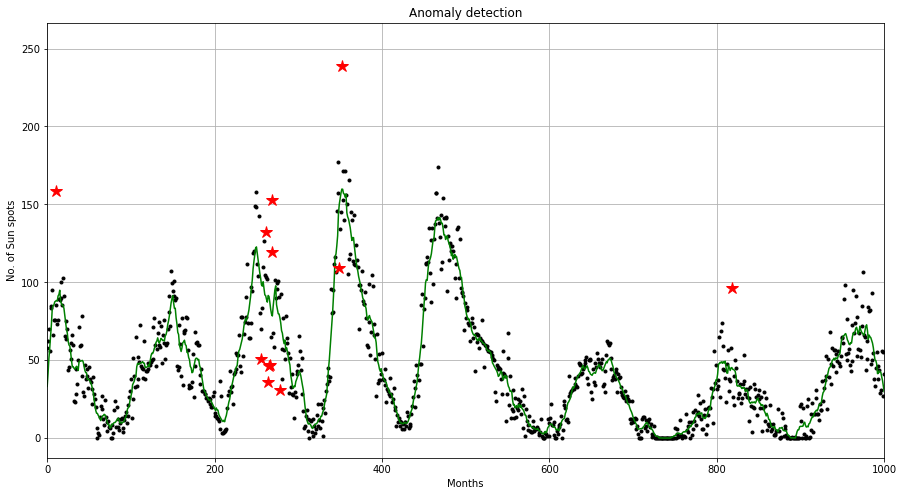

Information about the anomalies model:
{'standard_deviation': 11.424, 'anomalies_dict': OrderedDict([(10, 158.6), (253, 142.5), (255, 51.0), (262, 132.2), (264, 36.0), (268, 152.7), (278, 31.1), (349, 109.3), (352, 238.9), (361, 165.7), (818, 96.2), (986, 93.4), (1055, 206.3), (1069, 84.8), (1172, 107.1), (1182, 52.2), (1185, 180.4), (1464, 88.3), (1735, 129.2), (1882, 107.2), (1890, 103.6), (1897, 108.2), (2023, 154.5), (2025, 72.2), (2027, 129.3), (2171, 108.0), (2274, 165.3), (2380, 201.3), (2390, 94.8), (2391, 189.7), (2503, 158.0), (2518, 152.3), (2520, 217.4), (2521, 143.1), (2527, 199.6), (2755, 58.1), (2756, 138.2), (2789, 90.9), (2807, 127.0), (2885, 196.2), (2886, 126.9), (2897, 105.4), (2899, 200.3), (3005, 137.7), (3018, 170.1), (3032, 150.7)])}


In [5]:
# Run main script.
x = data_as_frame['Months']
y = data_as_frame['SunSpots']

# plot the results
plot_results(x, y=y, window_size=10, text_xlabel="Months", sigma_value=3, text_ylabel="No. of Sun spots")
events = explain_anomalies(y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:")
print(events)

### Experiment with the arguments

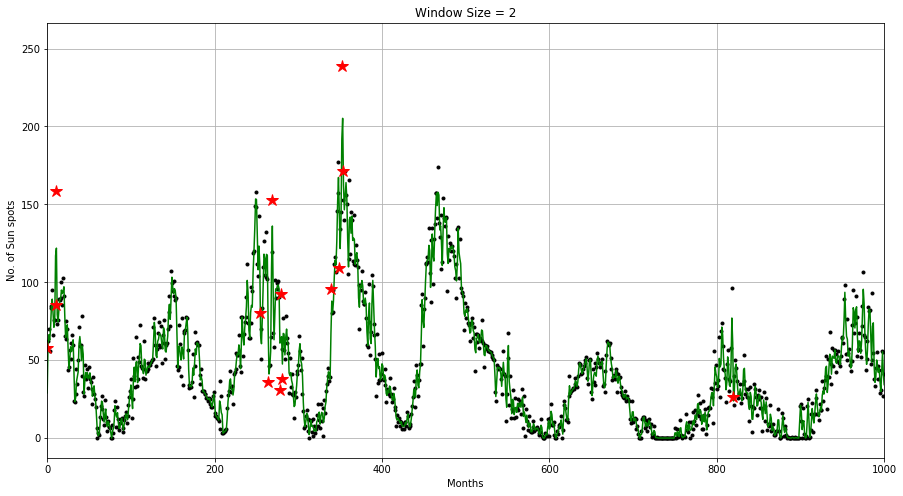

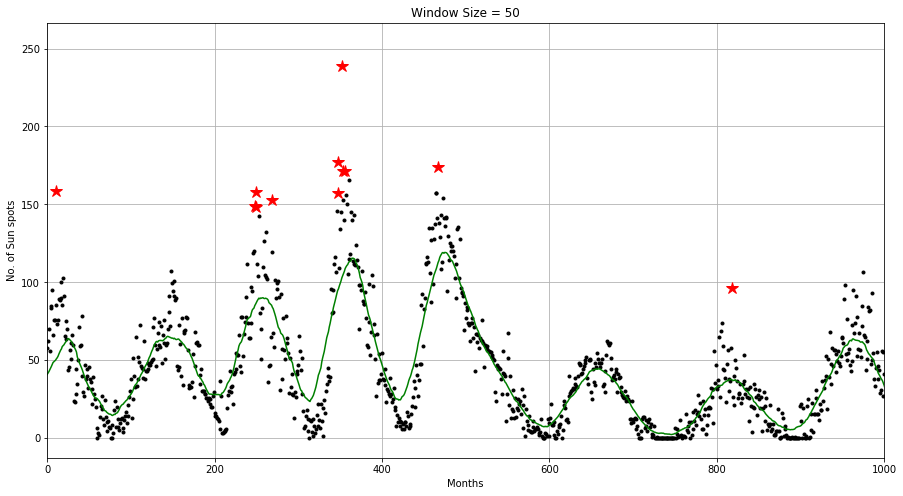

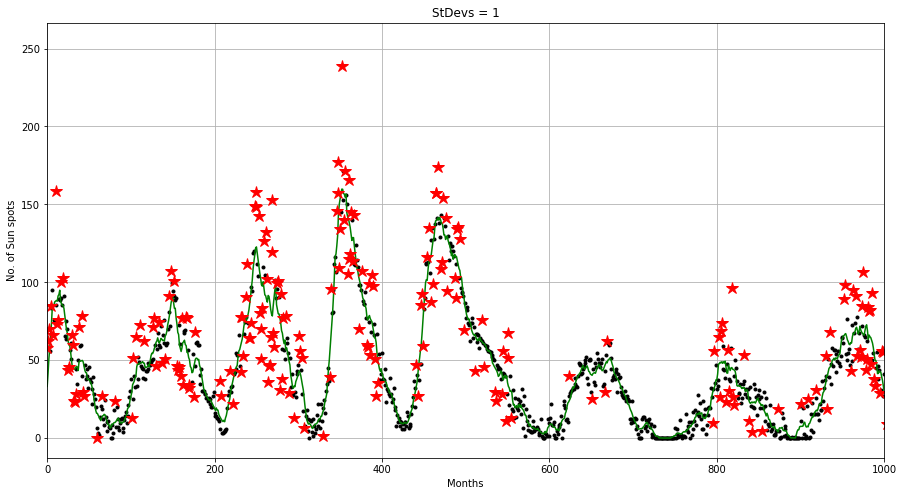

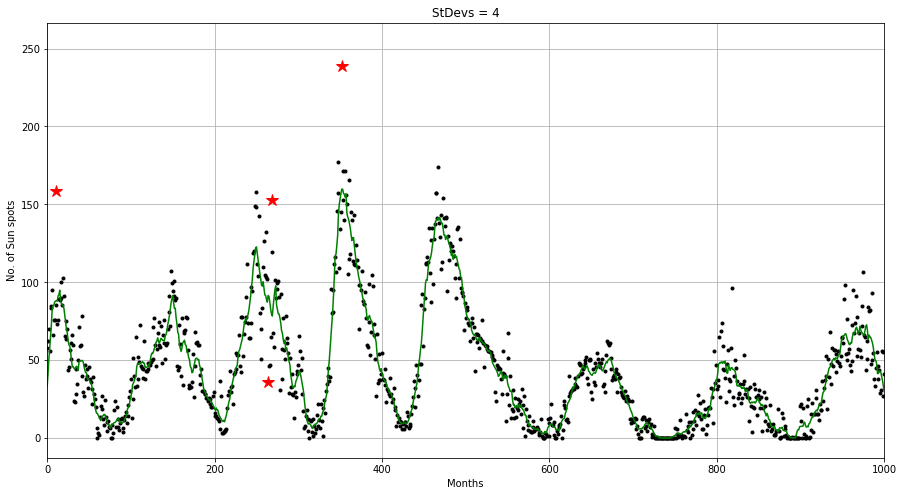

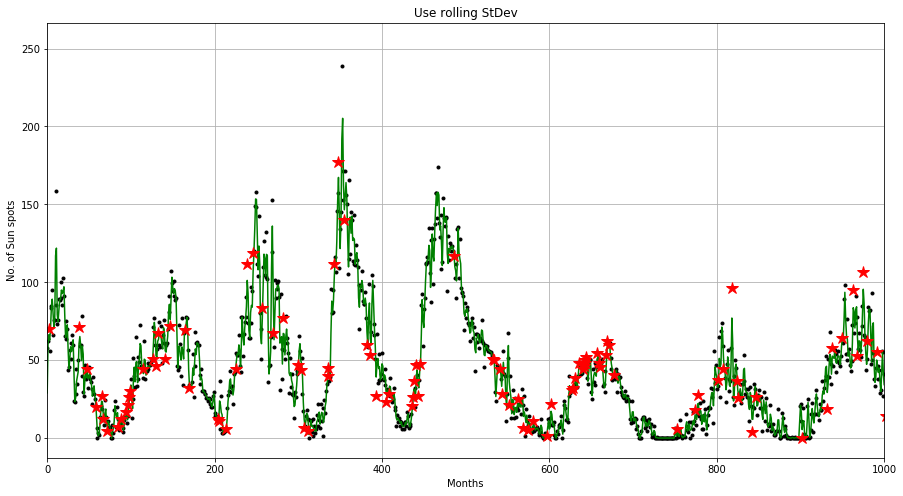

In [6]:
# Play around with some arguments.

# Window size:
plot_results(x, y=y, window_size=2, text_xlabel="Months", sigma_value=3, text_ylabel="No. of Sun spots", title="Window Size = 2")
plot_results(x, y=y, window_size=50, text_xlabel="Months", sigma_value=3, text_ylabel="No. of Sun spots", title="Window Size = 50")

# Sigma value:
plot_results(x, y=y, window_size=10, text_xlabel="Months", sigma_value=1, text_ylabel="No. of Sun spots", title="StDevs = 1")
plot_results(x, y=y, window_size=10, text_xlabel="Months", sigma_value=4, text_ylabel="No. of Sun spots", title="StDevs = 4")

# Rolling StDev:
plot_results(x, y=y, window_size=2, text_xlabel="Months", sigma_value=3, applying_rolling_std=True, text_ylabel="No. of Sun spots", title="Use rolling StDev")

### Investigate how the functions work

In [7]:
## plot_results() - clear.

In [8]:
## moving_average()

data = pd.Series([1.3, 1., 2.4, 1.5, 2.9, 3.5, 4.5, 2.3, 2.2, 1., .6])
window_size = 5
data_ma = moving_average(data, window_size=window_size)
data_ma

array([0.94, 1.24, 1.82, 2.26, 2.96, 2.94, 3.08, 2.7 , 2.12, 1.22, 0.76])

In [9]:
window = np.ones(int(window_size)) / float(window_size)
window

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [10]:
# Convolution step - note the "modes" (relate to boundaries)
convolved_1 = np.convolve(data, window, mode="full")
convolved_2 = np.convolve(data, window, mode="same")
convolved_3 = np.convolve(data, window, mode="valid")
display(convolved_1, convolved_2, convolved_3)

array([0.26, 0.46, 0.94, 1.24, 1.82, 2.26, 2.96, 2.94, 3.08, 2.7 , 2.12,
       1.22, 0.76, 0.32, 0.12])

array([0.94, 1.24, 1.82, 2.26, 2.96, 2.94, 3.08, 2.7 , 2.12, 1.22, 0.76])

array([1.82, 2.26, 2.96, 2.94, 3.08, 2.7 , 2.12])

In [11]:
## explain_anomalies()

avg = moving_average(data, window_size)
residual = np.array(data) - avg
std = np.std(residual)

display(avg, residual, std)

array([0.94, 1.24, 1.82, 2.26, 2.96, 2.94, 3.08, 2.7 , 2.12, 1.22, 0.76])

array([ 0.36, -0.24,  0.58, -0.76, -0.06,  0.56,  1.42, -0.4 ,  0.08,
       -0.22, -0.16])

0.5683207102966301

In [12]:
sigma_multiplier = 1.0

l = list(
    (index, y_i) for index, y_i, avg_i in zip(count(), data, avg)
    if (y_i > avg_i + (sigma_multiplier*std)) | (y_i < avg_i - (sigma_multiplier*std))
)

print(l)

[(2, 2.4), (3, 1.5), (6, 4.5)]


In [17]:
# The logic of this complicated statement...

# Zipping:
display(zip(count(), data, avg))
display(list(zip(count(), data, avg)))  # count() - seems to be a 0, 1, 2, 3 generator. https://docs.python.org/3.7/library/itertools.html#itertools.count

# Don't return the avg_i value:
display(list((index, y_i) for index, y_i, avg_i in zip(count(), data, avg)))

# And add the if condition if outside sigma_multiplier stdevs:
display(
    list(
        (index, y_i) for index, y_i, avg_i in zip(count(), data, avg) 
        if (y_i > avg_i + (sigma_multiplier*std)) | (y_i < avg_i - (sigma_multiplier*std)))
)

[(0, 1.3, 0.94),
 (1, 1.0, 1.24),
 (2, 2.4, 1.8199999999999998),
 (3, 1.5, 2.2600000000000002),
 (4, 2.9, 2.96),
 (5, 3.5, 2.94),
 (6, 4.5, 3.08),
 (7, 2.3, 2.7),
 (8, 2.2, 2.1199999999999997),
 (9, 1.0, 1.22),
 (10, 0.6, 0.7600000000000001)]

[(0, 1.3),
 (1, 1.0),
 (2, 2.4),
 (3, 1.5),
 (4, 2.9),
 (5, 3.5),
 (6, 4.5),
 (7, 2.3),
 (8, 2.2),
 (9, 1.0),
 (10, 0.6)]

[(2, 2.4), (3, 1.5), (6, 4.5)]

In [52]:
## explain_anomalies_rolling_std()

# Uncomment lines as needed.

residual = pd.Series(residual)
print(" residual:")
print(type(residual))
# display(residual)

# Difference from the non-rolling-std version only in the std - we use an array of rolling std here.

testing_std = residual.rolling(window_size).std()  # Old API: pd.rolling_std(residual, window_size)
print("\n", "testing_std:")
print(type(testing_std))
# display(testing_std)  # Note that the first window_size-1 items are NaNs in the way .rolling(window_size).std() works. 

testing_std_as_df = pd.DataFrame(testing_std)
print("\n", "testing_std_as_df:")
print(type(testing_std_as_df))
# display(testing_std_as_df)  # Converted to DataFrame.

# Fixing the NaN gap...
# print("\n", "testing_std_as_df.iloc[window_size - 1]")
# display(testing_std_as_df.iloc[window_size - 1].values)  # <-- The first non-empty item.
# print("\n", "testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1])")
# display(testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]))  # <-- Basically fill the NaN's with the first non-empty item (backfill).
# print("\n", "testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3)")
# display(testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3))  # <-- Round to 3 dp.
print("\n", "testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0]")
print(type(testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0]))
# display(testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0])  # <-- Revert back to Series (from DataFrame). 

print()
print("END RESULT:")
rolling_std = testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
display(rolling_std)

 residual:
<class 'pandas.core.series.Series'>

 testing_std:
<class 'pandas.core.series.Series'>

 testing_std_as_df:
<class 'pandas.core.frame.DataFrame'>

 testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0]
<class 'pandas.core.series.Series'>

END RESULT:


[0.525, 0.525, 0.525, 0.525, 0.525, 0.567, 0.813, 0.86, 0.705, 0.73, 0.734]

## Generated data

### Helper functions

In [134]:
# Convenience function to add noise
def noise(yval):
    """ Helper function to generate random points """
    np.random.seed(0)
    return 0.2 * np.asarray(yval) * np.random.normal(1, 0.2, size=len(yval))

# Generate a random dataset
def generate_random_dataset(size_of_array=1000, random_state=0):
    """ Helps in generating a random dataset which has a normal distribution
    Args:
    -----
        size_of_array (int): number of data points
        random_state (int): to initialize a random state

    Returns:
    --------
        a list of data points for dependent variable, pandas.Series of independent variable
    """
    np.random.seed(random_state)
    y = np.random.normal(0, 0.5, size_of_array)
    x = range(0, size_of_array)
    y_new = \
    noise(
        [
            y_i + index**((size_of_array - index)/size_of_array)
            for index, y_i in zip(count(), y)
        ]
    )
    return x, pd.Series(y_new)

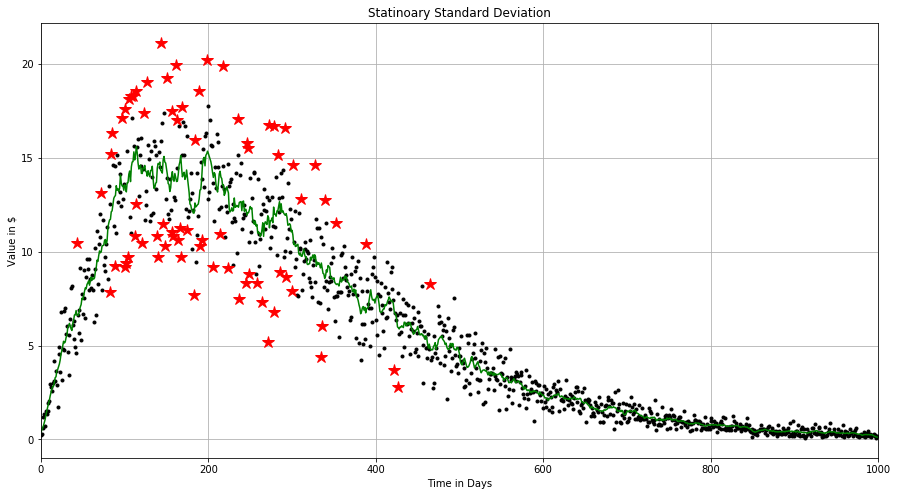

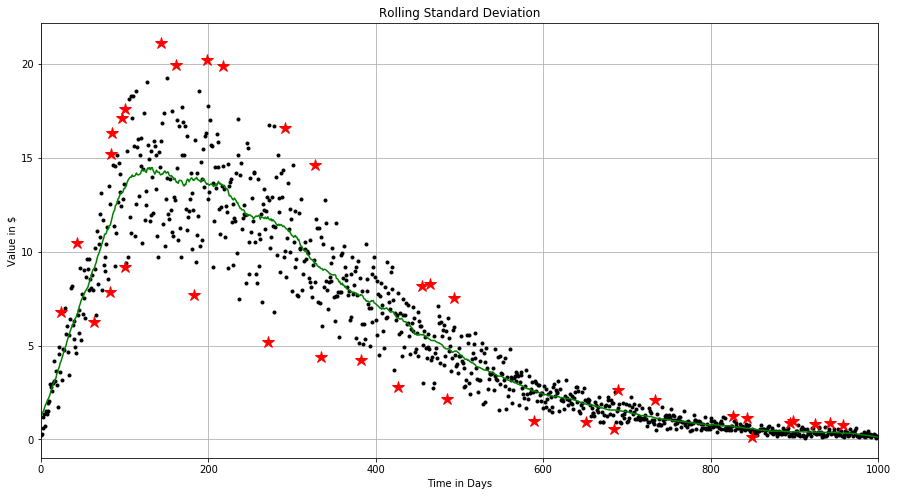

In [136]:
# Lets play
x1, y1 = generate_random_dataset()
# Using stationary standard deviation over a continuous sample replicating
plot_results(x1, y1, window_size=12, sigma_value=2, text_xlabel="Time in Days", text_ylabel="Value in $", title="Statinoary Standard Deviation")

# using rolling standard deviation for
x1, y1 = generate_random_dataset()
plot_results(x1, y1, window_size=50, sigma_value=2, text_xlabel="Time in Days", text_ylabel="Value in $", title="Rolling Standard Deviation", applying_rolling_std=True)

### Investigate how the functions work

In [137]:
prenoise = [1., 1., 1., 1.]
noised = noise(prenoise)
noised

array([0.27056209, 0.21600629, 0.23914952, 0.28963573])

In [139]:
np.random.seed(0)
a = np.random.normal(0, 1, size=len(prenoise))  # Just normal distr, mu=0, sigma=1 of array size (len) as given.
b = np.asarray(prenoise)
display(a, b, 0.2 * b * a)

array([1.76405235, 0.40015721, 0.97873798, 2.2408932 ])

array([1., 1., 1., 1.])

array([0.35281047, 0.08003144, 0.1957476 , 0.44817864])